In [1]:
# 학습에 필요한 라이브러리를 불러옵니다.
import os
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F
import cv2
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
import random
import numpy as np
import matplotlib.pyplot as plt
import copy
from PIL import Image
from google.colab import drive
import natsort
from sklearn.metrics import mean_squared_error 
import math

In [2]:
# 배치 크기
batch_size = 4

# 이미지의 채널 수로, GRAY 이미지이기 때문에 1 로 설정합니다.
nc = 1

# 디노이징 U-net을 통과하는 특징 데이터들의 채널 크기 설정을 위한 변수
ngf = 64

# 학습할 에폭 수
num_epochs = 30

# 옵티마이저의 학습률
lr = 0.0002

# Adam 옵티마이저의 beta 하이퍼파라미터
betas = (0.5, 0.999)

# 학습에 사용될 장치를 선택합니다.
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")


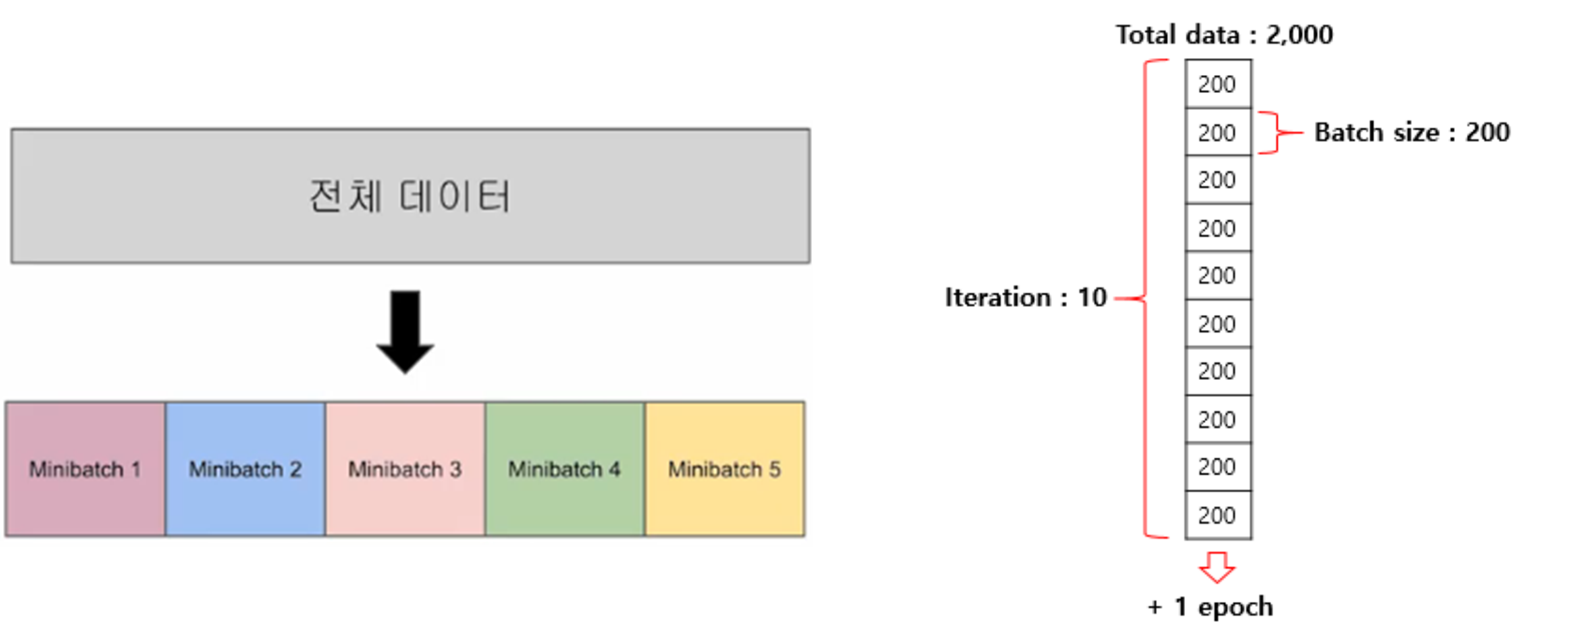

In [3]:
# 데이터를 처리할 custom dataset
class Custom_datasets(Dataset):
    def __init__(self,img_path,gt_path,transform=None):
        self.img = img_path
        self.gt = gt_path
        self.transform = transform
        
    def __len__(self):
        return len(self.img)
    
    def __getitem__(self, idx):
        image = Image.open(self.img[idx])
        gt = Image.open(self.gt[idx])
        

        image = self.transform(image)
        gt = self.transform(gt)

        return [image, gt]

In [4]:
# Google drive와 github를 연동하기 위한 코드
drive.mount('/content/drive/')                        # Google drive를 mount합니다.
path = '/content/drive/MyDrive/Tutorial_1026/'        # Tutorial_1026 폴더를 만듭니다.
os.makedirs(path,exist_ok=True)
os.chdir(path)
print(os.getcwd())
# github에서 데이터를 다운로드 받습니다.
try:
  !git clone https://github.com/Cheque93/Tutorial_1026.git .
except:
  pass

Mounted at /content/drive/
/content/drive/MyDrive/Tutorial_1026
fatal: destination path '.' already exists and is not an empty directory.


In [5]:
# Custom dataset을 구성합니다
# train/validation/test 셋을 설정합니다
train_path = path + 'imgs/train/'
train_noise = natsort.natsorted(np.char.add(train_path+'noise/',os.listdir(train_path+'noise')))
train_gt = natsort.natsorted(np.char.add(train_path+'gt/',os.listdir(train_path+'gt')))
print("Number of noise image for train: "+str(len(train_noise)))
print("Number of ground truth image for train: "+str(len(train_gt)))
valid_path = path + 'imgs/valid/'
valid_noise = natsort.natsorted(np.char.add(valid_path+'noise/',os.listdir(valid_path+'noise')))
valid_gt = natsort.natsorted(np.char.add(valid_path+'gt/',os.listdir(valid_path+'gt')))
print("Number of noise image for validation: "+str(len(valid_noise)))
print("Number of ground truth image for validation: "+str(len(valid_gt)))
test_path = path + 'imgs/test/'
test_noise = natsort.natsorted(np.char.add(test_path+'noise/',os.listdir(test_path+'noise')))
test_gt = natsort.natsorted(np.char.add(test_path+'gt/',os.listdir(test_path+'gt')))
print("Number of noise image for test: "+str(len(test_noise)))
print("Number of ground truth image for test: "+str(len(test_gt)))

# 데이터 transform을 설정합니다
# 현재 적용된 transform은 mean, variance 0.5로 normalize transform 입니다
data_transforms = transforms.Compose([  transforms.ToTensor(),
                                        transforms.Normalize((0.5),(0.5))
                                        ])
train_set = Custom_datasets(train_noise,train_gt,data_transforms)
valid_set = Custom_datasets(valid_noise,valid_gt,data_transforms)
test_set = Custom_datasets(test_noise,test_gt,data_transforms)
dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'valid': DataLoader(valid_set, batch_size=4, shuffle=True, num_workers=0),
    'test': DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)
}

Number of noise image for train: 100
Number of ground truth image for train: 100
Number of noise image for validation: 14
Number of ground truth image for validation: 14
Number of noise image for test: 16
Number of ground truth image for test: 16


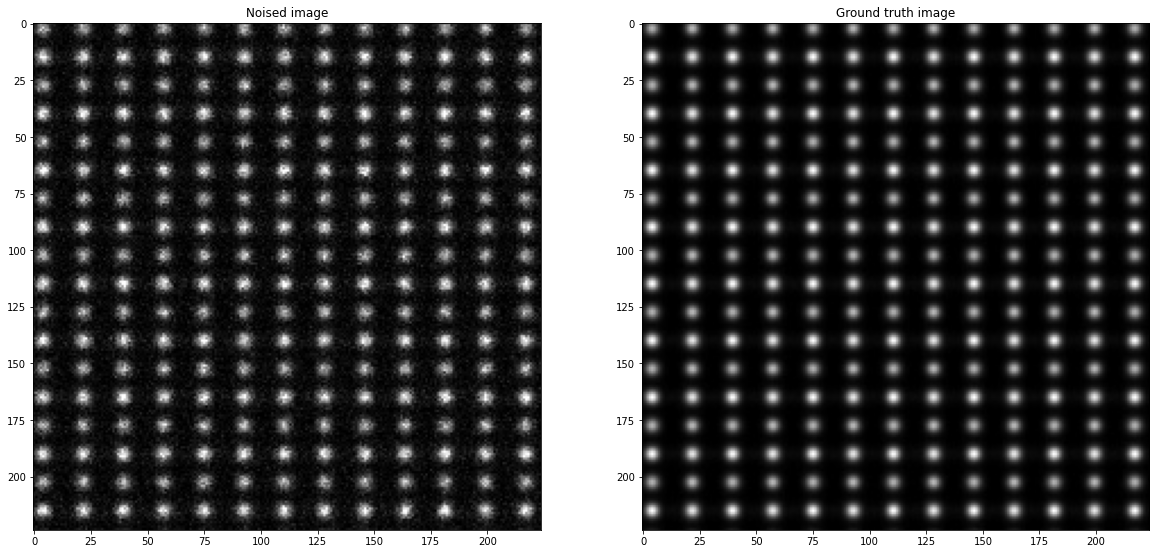

In [6]:
# dataloader 확인
tmp_dataloader = iter(dataloaders['test'])
tmp_batch = next(tmp_dataloader)
tmp_noise = tmp_batch[0].cpu().detach().numpy()[0].transpose((1,2,0))           # tensor -> numpy로 변환
tmp_gt = tmp_batch[1].cpu().detach().numpy()[0].transpose((1,2,0))
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].set_title('Noised image')
ax[0].imshow(tmp_noise[:,:,0],cmap='gray')
ax[1].set_title('Ground truth image')
ax[1].imshow(tmp_gt[:,:,0],cmap='gray')


In [7]:
# 디노이징 U-net 모델
class Down(nn.Module):                                                                        # Encoding 부분의 Down layer
    def __init__(self, in_channels, out_channels):                                            # 2D MaxPooling과 convolution, batch normalization, PReLU로 구성됩니다.
        super().__init__()                                                                    # Layer를 거치면 사이즈는 1/2로 감소하고 feature는 2배 증가합니다.
        self.conv = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1,stride=1),
            nn.BatchNorm2d(out_channels),
            nn.PReLU()
            )

    def forward(self, x):
        return self.conv(x)
    
class Up(nn.Module):                                                                          # Decoding 부분의 Up layer
    def __init__(self, in_channels, out_channels):                                            # 2D transposed convolution과 batch normalization, PReLU로 구성됩니다.
        super().__init__()                                                                    # Layer를 거치면 사이즈는 2배 증가하고 feature는 1/2로 감소합니다.
        self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.PReLU()
            )
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW                    
        diffY = x2.size()[2] - x1.size()[2]                                                   # UNet의 skip-connection을 위해 padding을 통해 사이즈를 조정합니다.
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
class UNet(nn.Module):                                                                        # 앞서 작성한 down 및 up layer를 사용한 UNet 모델
    def __init__(self, n_channels):
        super(UNet, self).__init__()
        self.n_channels = n_channels                                                          # Input image의 channel
        self.inc = nn.Conv2d(n_channels, ngf,kernel_size=3, padding=1)                        # Init convolution
        self.down1 = Down(ngf, ngf*2)                                                         # Down layer를 통해 사이즈는 1/2로 감소하고 feature는 2배 증가합니다.
        self.down2 = Down(ngf*2, ngf*4)
        self.up1 = Up(ngf*4, ngf*2)                                                           # Up layer를 통해 사이즈는 2배 증가하고 feature는 1/2로 감소합니다.
        self.up2 = Up(ngf*2, ngf)
        self.out_conv = nn.Conv2d(ngf, n_channels, kernel_size=1)                             # channel 크기를 맞추기 위한 out convolution

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x = self.up1(x3, x2)
        x = self.up2(x, x1)
        logits =  self.out_conv(x)
        
        return logits

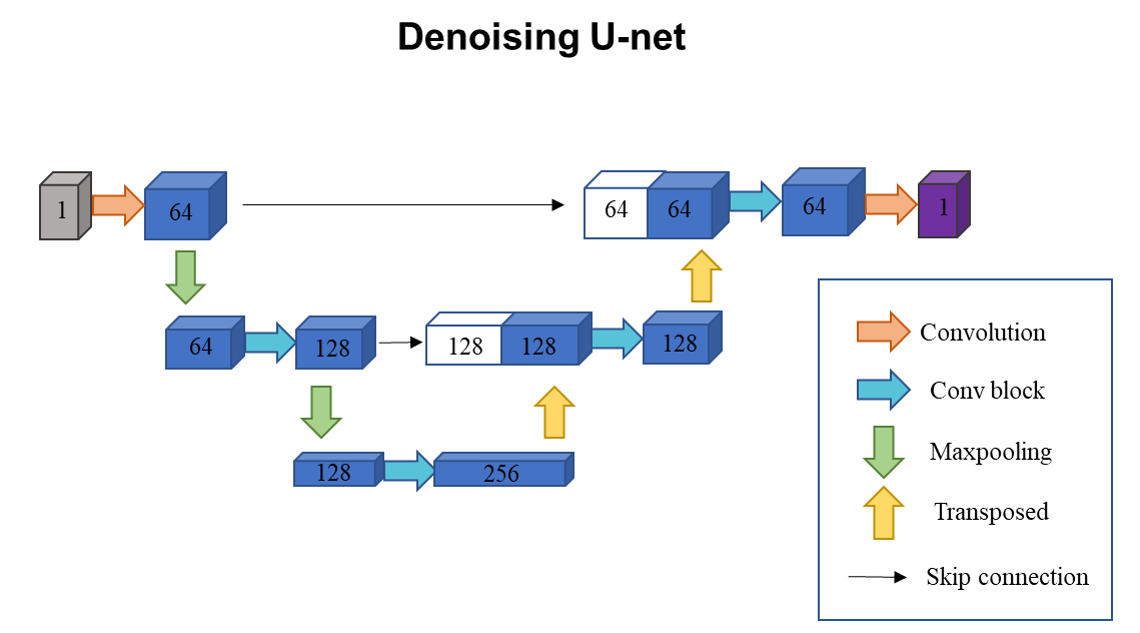

In [8]:
# 디노이징 U-net에 적용시킬 커스텀 가중치 초기화 함수
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
# 모델 구성 부분
# 앞서 구성한 Denoising U-net을 생성하고 초기화
DNnet = UNet(n_channels = nc).to(device)
DNnet.apply(weights_init)

UNet(
  (inc): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down1): Down(
    (conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): PReLU(num_parameters=1)
    )
  )
  (down2): Down(
    (conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): PReLU(num_parameters=1)
    )
  )
  (up1): Up(
    (up): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (conv): Sequential(
      (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=

In [10]:
# MSELoss 함수의 인스턴스를 생성합니다
criterion = torch.nn.MSELoss()

# 학습에서 사용할 Adam옵티마이저를 생성합니다
optimizer = torch.optim.Adam(DNnet.parameters(), lr=lr, betas=betas)

In [11]:
# 모델 학습 부분
# Loss를 저장할 변수를 선언
Tr_losses = np.zeros((num_epochs))                                              
Val_losses = np.zeros((num_epochs))

# 최적의 모델을 저장하기 위한 loss값의 기준치
best_loss = 1e5                                                                 

print("Starting Training Loop...")
# 에폭(epoch) 반복
for epoch in range(num_epochs):
    # 한 에폭 내 train 과 valid 페이즈를 나누어 
    # train 페이즈에만 파라미터 업데이트하도록 설정합니다
    for phase in ['train','valid']:
        if phase=='train':
            #train 모드
            DNnet.train()
        else:
            #valid 모드
            DNnet.eval()
        for i, data in enumerate(dataloaders[phase]):
            # 배치들의 사이즈나 사용할 디바이스(GPU)에 맞게 조정합니다
            inputs = data[0].to(device)
            labels = data[1].to(device)
            
            # 기존에 남아있던 기울기를 초기화 합니다.
            optimizer.zero_grad()

            # 노이즈 데이터 배치를 디노이징 U-net에 인풋으로 넣습니다.
            denoised_imgs = DNnet(inputs)
            
            # 결과 값과 정답 간의 손실값을 계산합니다.
            loss = criterion(denoised_imgs, labels)

            
            if phase == 'train':
                # 역전파 및 최적화 
                loss.backward()
                optimizer.step()
                # 해당 배치의 train 손실 값을 더해 저장
                Tr_losses[epoch] += loss.data.item()
            else:
                # 해당 배치의 valid 손실 값을 더해 저장
                Val_losses[epoch] += loss.data.item()
                
            # train상태의 손실값을 현재 배치까지 평균내어 출력합니다.
            if phase=='train':
                print('\rtrain: [%d/%d][%d/%d]\tLoss: %.4f'
                      % (epoch+1, num_epochs, i+1, len(dataloaders['train']),
                         Tr_losses[epoch]/(i+1)),end='')
                
        # 훈련을 한 에폭(모든 배치 사용) 마친 후 train 손실 값을 평균 내어 저장합니다.     
        if phase=='train':
            Tr_losses[epoch] = Tr_losses[epoch]/(i+1)
            
        # 훈련을 한 에폭 마친 후 valid 손실 값을 평균 내어 저장 및 출력합니다..   
        if phase=='valid':
            Val_losses[epoch] = Val_losses[epoch]/(i+1)  
            print('\rvalid: [%d/%d][%d/%d]\tLoss: %.4f'
                  % (epoch+1, num_epochs, i+1, len(dataloaders['valid']),
                     Val_losses[epoch]),end='')
            if Val_losses[epoch] < best_loss:
                print("\nsaving best model with %.4f loss"%(Val_losses[epoch]),end='')
                best_loss = Val_losses[epoch]
                best_model_wts = copy.deepcopy(DNnet.state_dict())
        print()
    print('________________________________________________')
    print()

Starting Training Loop...
train: [1/30][25/25]	Loss: 0.3676
valid: [1/30][4/4]	Loss: 0.4301
saving best model with 0.4301 loss
________________________________________________

train: [2/30][25/25]	Loss: 0.2078
valid: [2/30][4/4]	Loss: 0.1399
saving best model with 0.1399 loss
________________________________________________

train: [3/30][25/25]	Loss: 0.1314
valid: [3/30][4/4]	Loss: 0.0779
saving best model with 0.0779 loss
________________________________________________

train: [4/30][25/25]	Loss: 0.0792
valid: [4/30][4/4]	Loss: 0.0204
saving best model with 0.0204 loss
________________________________________________

train: [5/30][25/25]	Loss: 0.0447
valid: [5/30][4/4]	Loss: 0.0186
saving best model with 0.0186 loss
________________________________________________

train: [6/30][25/25]	Loss: 0.0253
valid: [6/30][4/4]	Loss: 0.0043
saving best model with 0.0043 loss
________________________________________________

train: [7/30][25/25]	Loss: 0.0135
valid: [7/30][4/4]	Loss: 0.0246
__

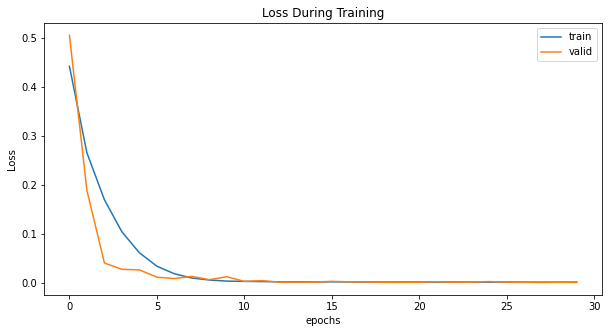

In [ ]:
#학습과정의 loss를 출력합니다.
plt.figure(figsize=(10,5))
plt.title("Loss During Training")
plt.plot(Tr_losses,label="train")
plt.plot(Val_losses,label="valid")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# 저장한 best weight를 불러옵니다.
DNnet.load_state_dict(best_model_wts)

# test셋에서 검증합니다.
DNnet.eval()
tb = iter(dataloaders['test'])

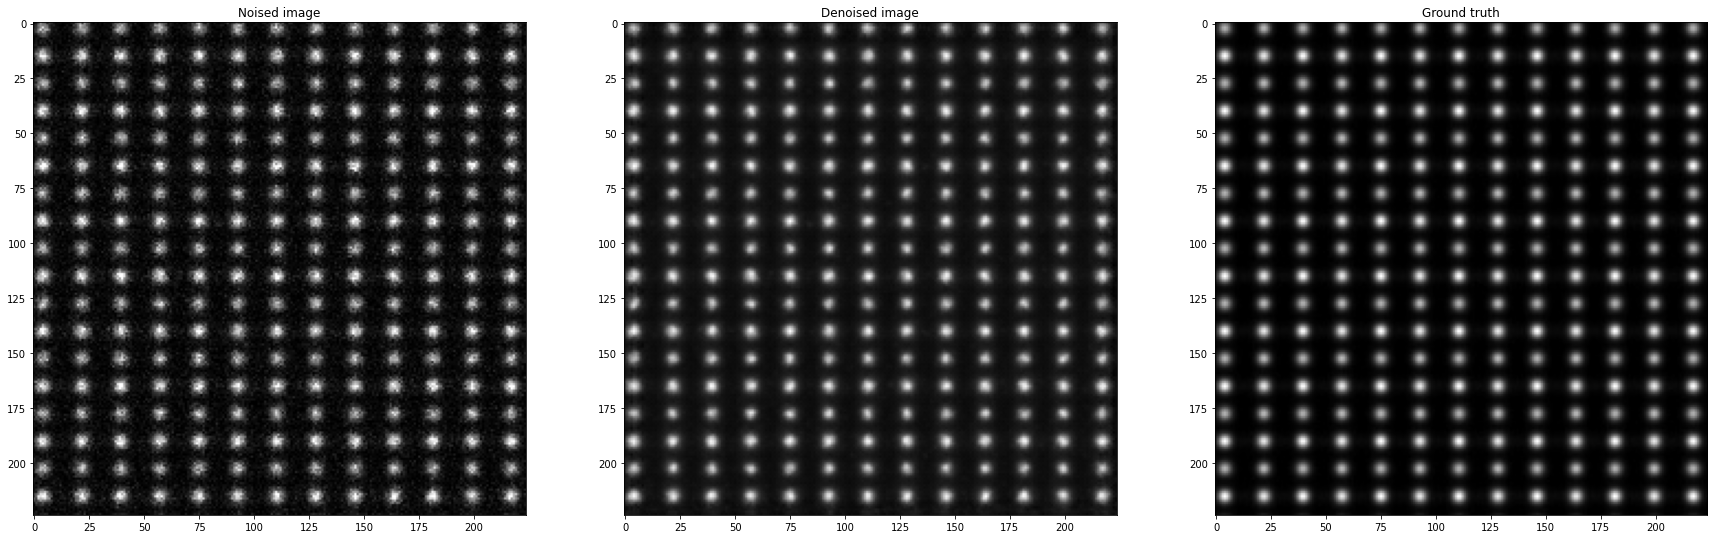

0.0008380796


In [ ]:
# test셋에서 데이터를 불러옵니다.
test_batch = next(tb)
t_noise = test_batch[0].to(device)
# tensor를 numpy로 바꿔주는 과정
t_img = test_batch[0].cpu().detach().numpy()[0].transpose((1,2,0))
t_gt = test_batch[1].cpu().detach().numpy()[0].transpose((1,2,0))
# 학습된 모델로 noise 이미지를 denoising 합니다.
test_result = DNnet(t_noise)
test_result = test_result.cpu().detach().numpy()[0].transpose((1,2,0))
# transform에의해 노말라이즈된 데이터값 복원
test_result = (test_result+1)*0.5
t_gt = (t_gt+1)*0.5
t_img = (t_img+1)*0.5
# 결과를 출력합니다.
fig, ax = plt.subplots(1,3,figsize=(30,30))
ax[0].set_title('Noised image')
ax[0].imshow(t_img[:,:,0],cmap='gray')
ax[1].set_title('Denoised image')
ax[1].imshow(test_result[:,:,0],cmap='gray')
ax[2].set_title('Ground truth')
ax[2].imshow(t_gt[:,:,0],cmap='gray')
plt.show()

# mean squared error를 계산합니다.
mse = mean_squared_error(t_gt[:,:,0],test_result[:,:,0])
print("MSE: %.6f" %(mse))

In [ ]:
# psnr을 계산하기 위한 함수
def calc_psnr(truth,compare,pixel_max=255.0):
    mse = np.mean((truth-compare)**2)
    if mse == 0:
        return 100
    return 20*math.log10(pixel_max/math.sqrt(mse))


In [ ]:
# 전체 test셋에 대해 pnsr과 mse를 계산합니다.
tb = iter(dataloaders['test'])
total_mse = []
total_psnr = []
for test_batch in tb:
    t_noise = test_batch[0].cuda()
    t_img = test_batch[0].cpu().detach().numpy()[0].transpose((1,2,0))
    t_gt = test_batch[1].cpu().detach().numpy()[0].transpose((1,2,0))
    test_result = DNnet(t_noise).cpu().detach().numpy()[0]
    test_result = test_result.transpose((1,2,0))
    test_result = (test_result+1)*127.5
    t_gt = (t_gt+1)*127.5
    t_img = (t_img+1)*127.5
    mse = mean_squared_error(t_gt[:,:,0]/255,test_result[:,:,0]/255)
    p = calc_psnr(t_gt[:,:,0],test_result[:,:,0])
    total_mse.append(mse)
    total_psnr.append(p)
# 평균 mse와 pnsr을 계산합니다.
print("평균 MSE: %.6f" %(np.mean(total_mse)))
print("평균 PSNR: %.6f"  %(np.mean(total_psnr)))


0.00067723886
31.76850097154854
